In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
# from tensorflow.keras.layers.experimental import preprocessing 


In [2]:
# target_shape = (128,128)
# target_shape = (320,320)
target_shape = (None,None)

## Model definition

In [3]:
## upsample from pix2pix tf example
# https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
def upsample(filters, size, activation="True"):
    """Upsamples an input.
    Conv2DTranspose => Batchnorm => Dropout => Relu
    Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
    Returns:
    Upsample Sequential Model
    """

    # initializer = tf.random_normal_initializer(0., 0.02)
    initializer = tf.keras.initializers.variance_scaling(scale=2)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    if activation:
        result.add(tf.keras.layers.ReLU())

    return result

In [4]:
def attention_block(skip, x, filters,i):
    # https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831
    # https://arxiv.org/pdf/1804.03999.pdf
    
    # x shape is skip/2
    
    initializer = tf.keras.initializers.variance_scaling(scale=2)
    
#     skip = tf.keras.layers.Conv2D(filters, 1, strides=1,padding='same', kernel_initializer=initializer, name='attention_skip_'+str(i))(skip) ## change channel number

    theta = tf.keras.layers.Conv2D(filters, 1, strides=2, padding='same', kernel_initializer=initializer,name = 'theta_'+str(i))(skip) ## downsample skip connection
    phi = tf.keras.layers.Conv2D(filters, 1, strides=1, padding='same', kernel_initializer=initializer, name = 'phi_'+str(i))(x) # change channel number. 
 
#     result = tf.keras.layers.Concatenate(name='result_phi_theta'+str(i))([phi, theta])
    result = tf.keras.layers.Add(name='add_atention' + str(i))([phi, theta])
    
    result = tf.keras.layers.ReLU(name='relu_at_'+str(i))(result)
    result = tf.keras.layers.Conv2D(1,1,1,padding='same', kernel_initializer=initializer,name='flat_at_'+str(i))(result)
    result = tf.keras.layers.Activation('sigmoid',name='sig_at_'+str(i))(result)
    
    result = tf.keras.layers.Conv2DTranspose(filters, 3, strides=2, padding='same', kernel_initializer=initializer, name='trans_at_'+str(i))(result) # upsample size -> skip
    
    result = tf.keras.layers.Multiply(name='mul_at_'+str(i))([result, skip])
    
    return result 
    
def conv_block(inputs, filters, size=3, max_pooling=False, activation=True):
    
    initializer = tf.keras.initializers.variance_scaling(scale=2)

    result = tf.keras.layers.Conv2D(filters, size, strides=1,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False)(inputs)

    result = tf.keras.layers.BatchNormalization()(result)

    result = tf.keras.layers.ReLU()(result)
    
    result = tf.keras.layers.Conv2D(filters, size, strides=1,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False)(result)
    result = tf.keras.layers.BatchNormalization()(result)
    
    identity = tf.keras.layers.Conv2D(filters, 1, strides=1,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False)(inputs)
    
    result = tf.keras.layers.Add()([identity, result])
    if activation:
        result = tf.keras.layers.ReLU()(result)
    
    if max_pooling:
        result = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(result)
    
    return result

In [5]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=target_shape + (3,))

    filters = [32,64,128,256,512]
    
    # Downsampling through the model
    skips = down_stack(inputs)

    x = skips[-1]
    x = conv_block(x, filters[-1], max_pooling=False) 
    
    skips = reversed(skips[:-1])
    filters = filters[:-1]
    filters.reverse()
    
    i =0 
    for up, skip in zip(up_stack, skips):
        
        ## atention part
        skip = tf.keras.layers.Conv2D(filters[i], 3, 1, padding='same')(skip) # change filters from backbone
        skip = tf.keras.layers.BatchNormalization()(skip)
        skip = tf.keras.layers.ReLU()(skip)

        skip = attention_block(skip, x, filters[i], i) 
      
        x = up(x)
        x = tf.keras.layers.Concatenate(name='concat_unet_'+str(i))([x, skip])
        
        ## extra conv block
        x = conv_block(x, filters[i], max_pooling=False)
        i += 1

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)
    x = conv_block(x, output_channels, max_pooling=False, activation=False)  ## extra conv block

    return tf.keras.Model(inputs=inputs, outputs=x)

## Get dataset 

#### Utils

In [6]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    
    class_weights = tf.constant([9.0, 1.0])
    
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

def one_hot(image, mask, weights):
    mask_one_hot = tf.one_hot(mask, 2, on_value=1.0, off_value=0.0,  axis=-1)[:,:,0,:]
    return image, mask_one_hot, weights

def one_hot_val(image, mask):
    mask_one_hot = tf.one_hot(mask, 2, on_value=1.0, off_value=0.0,  axis=-1)[:,:,0,:]
    return image, mask_one_hot


#### Add icons image augumentation

In [7]:
def preprocess_icons(icon_path):
    image_string = tf.io.read_file(icon_path)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (80,70))
#     image = tf.image.random_hue(image, 0.2)
#     image = tf.image.random_contrast(image, 0.3,0.8)
    
    return (image, tf.random.uniform([]), tf.random.uniform([]))


def add_icon(input_image, input_icon, px, py, image_mask):
    
    im_size = tf.shape(input_image)[:2]
    icon_size = tf.shape(input_icon)[:2]
      
    valid_space = im_size-icon_size

    icon_yx = tf.cast(valid_space, tf.float32)*tf.convert_to_tensor([py, px], dtype=tf.float32)
    icon_yx = tf.cast(icon_yx, tf.int32)
    
    left_pad = icon_yx[1]
    up_pad = icon_yx[0]
    down_pad = im_size[0] - up_pad - icon_size[0]
    right_pad = im_size[1] - left_pad - icon_size[1] 
    
    padding = tf.convert_to_tensor([ [up_pad, down_pad], [left_pad, right_pad], [0, 0] ], dtype=tf.int32)
    
    sample_icon = tf.pad(input_icon, padding, constant_values=0)

    a = tf.cast(sample_icon*255, tf.int32)
    b = tf.cast(input_image, tf.int32)

    mask = tf.where(a>0,0,1)
    
    if tf.math.reduce_min(tf.bitwise.bitwise_or(mask, image_mask)) == 0:
        return input_image
    
    input_image = b*mask + a
    input_image = tf.cast(input_image, tf.float32)
    
    return input_image

### Preprocess and image augumentation

In [59]:
def preprocess_images(input_image, input_mask):
    image_string = tf.io.read_file(input_image)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image * 255


    mask_string = tf.io.read_file(input_mask)
    mask = tf.image.decode_png(mask_string, channels=1)
    mask = tf.where(mask < 224, 0, 1) #orig     
    # mask = tf.where(mask < 224, 1, 0) # when saving resized images
    
    
 
    image, mask = resize_image(image, mask)
    
    return image, mask

def preprocess_images_fname(input_image, input_mask):
    image_string = tf.io.read_file(input_image)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image * 255


    mask_string = tf.io.read_file(input_mask)
    mask = tf.image.decode_png(mask_string, channels=1)*255
    # mask = tf.where(mask < 224, 1, 0)
 
    # image, mask = resize_image(image, mask)
    
    return image, mask, input_image, input_mask

def resize_image(image, mask, w=320, h=320, stride=32.0, keep_aspect_ratio=False):
    
    # resize image without changing aspect ratio to a size divisible by stride (for unet conv and deconv match)

    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    resize_shape = tf.cast(tf.constant([w,h]), dtype=tf.float32)
    
    if keep_aspect_ratio:
        ar_factor = tf.math.reduce_max(resize_shape / image_shape)
        resize_shape = image_shape * ar_factor

    resize_shape = tf.cast(
        tf.math.ceil(resize_shape / stride) * stride, dtype=tf.int32
    )

    image_resize =  tf.image.resize(image, resize_shape, method='bilinear')
    
    mask = tf.cast(mask, tf.float32)
    mask_resize = tf.image.resize(mask, resize_shape, method='area')
    # mask_resize = tf.where(mask_resize<0.08, 1, 0) ## for savind resized images
    mask_resize = tf.where(mask_resize<0.9, 0, 1) ## for resising real time
    
    
    return (image_resize,mask_resize)

def augument_images(input_image, input_mask):
    
      
    rnd = tf.random.uniform([])
    if(rnd <0.5):
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
       
    for i in range(3):
        rnd = tf.random.uniform([])
        if(rnd <0.4):
            input_image = tf.image.rot90(input_image)
            input_mask = tf.image.rot90(input_mask)
    
    input_image = tf.image.random_brightness(input_image/255.0, 0.1)
    input_image = tf.clip_by_value(input_image,0,1)*255.0
    
    
    input_image = tf.image.random_contrast(input_image,  0.5, 0.9)
    input_image = tf.clip_by_value(input_image,0.0,255.0)


   
    return input_image, input_mask

def augument_images_icons(input_data, icons):
    
    input_image, input_mask = input_data
    icons, x, y = icons
    
    icon, px, py = icons[0], x[0], y[0] 
    input_image = add_icon(input_image, icon, px, py, input_mask)
    icon, px, py = icons[1], x[1], y[1] 
    input_image = add_icon(input_image, icon, px, py, input_mask)
    icon, px, py = icons[2], x[2], y[2] 
    input_image = add_icon(input_image, icon, px, py, input_mask)
    
    
        
    rnd = tf.random.uniform([])
    if(rnd <0.5):
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
       
    for i in range(3):
        rnd = tf.random.uniform([])
        if(rnd <0.4):
            input_image = tf.image.rot90(input_image)
            input_mask = tf.image.rot90(input_mask)
    
    input_image = tf.image.random_brightness(input_image/255.0, 0.1)
    input_image = tf.clip_by_value(input_image,0,1)*255.0
    
    
    input_image = tf.image.random_contrast(input_image,  0.5, 0.9)
    input_image = tf.clip_by_value(input_image,0.0,255.0)


   
    return input_image, input_mask

def keras_preprocess(input_image, input_mask):
    # image = tf.keras.applications.mobilenet.preprocess_input(input_image)
    # image = tf.keras.applications.resnet.preprocess_input(input_image)
    image = tf.keras.applications.densenet.preprocess_input(input_image)
    # image = tf.keras.applications.efficientnet.preprocess_input(input_image)
    
    return input_image, input_mask

In [60]:
# base_dir = './data/'
base_dir = './data/'
# base_dir = './data_resized/'


# base_dir = '/archive/floorplan/data-new-iteration/'

input_dir =base_dir+ "ground_truth/"
# input_dir =base_dir+ "transformed/"

target_dir = base_dir+"masks/"
img_size = (None, None)
num_classes = 2
# batch_size = 1
batch_size = 8


input_img_paths = \
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]

target_img_paths = \
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]


print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)
    
image_count = len(input_img_paths)

Number of samples: 691
./data/ground_truth/dan (1).png | ./data/masks/dan-masked (1).png
./data/ground_truth/dan (10).png | ./data/masks/dan-masked (10).png
./data/ground_truth/dan (100).png | ./data/masks/dan-masked (100).png
./data/ground_truth/dan (101).png | ./data/masks/dan-masked (101).png
./data/ground_truth/dan (102).png | ./data/masks/dan-masked (102).png
./data/ground_truth/dan (103).png | ./data/masks/dan-masked (103).png
./data/ground_truth/dan (104).png | ./data/masks/dan-masked (104).png
./data/ground_truth/dan (105).png | ./data/masks/dan-masked (105).png
./data/ground_truth/dan (106).png | ./data/masks/dan-masked (106).png
./data/ground_truth/dan (107).png | ./data/masks/dan-masked (107).png


### Shuffle data - optional

In [ ]:
mapIndexPosition = list(zip(input_img_paths, target_img_paths))
random.seed(10)
random.shuffle(mapIndexPosition)

shuffled_input_path = [x[0] for x in mapIndexPosition]
shuffled_target_path = [x[1] for x in mapIndexPosition]

shuffled_input_path, shuffled_target_path = zip(*mapIndexPosition)

shuffled_input_path = np.array(shuffled_input_path)
shuffled_target_path = np.array(shuffled_target_path)

for input_path, target_path in zip(shuffled_input_path[:10], shuffled_target_path[:10]):
    print(input_path, "|", target_path)


### Add icons image augumentation - optional

In [61]:
# Let's now split our dataset in train and validation.

print(image_count, 'images')

icons_dir = './icons/'

icons_paths = [
        os.path.join(icons_dir, fname)
        for fname in os.listdir(icons_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
icon_count = len(icons_paths)
icons_paths = icons_paths * (image_count//(icon_count//3))

icons_dataset = tf.data.Dataset.from_tensor_slices(icons_paths)
icons_dataset = icons_dataset.map(preprocess_icons)
icons_dataset = icons_dataset.shuffle(icon_count)
icons_dataset = icons_dataset.batch(3)
icons_dataset = icons_dataset.prefetch(tf.data.AUTOTUNE)

691 images


### Dataset

In [ ]:
train_num = round(image_count * 0.8) //batch_size * batch_size

input_img_dataset = tf.data.Dataset.from_tensor_slices(input_img_paths[:train_num ])
target_img_dataset = tf.data.Dataset.from_tensor_slices(target_img_paths[:train_num])

# input_img_dataset = tf.data.Dataset.from_tensor_slices(shuffled_input_path[:round(image_count * 0.8)])
# target_img_dataset = tf.data.Dataset.from_tensor_slices(shuffled_target_path[:round(image_count * 0.8)])

train_dataset = tf.data.Dataset.zip((input_img_dataset, target_img_dataset))
view_fname_dataset = train_dataset.map(preprocess_images_fname)

train_dataset = train_dataset.map(preprocess_images)

train_dataset = tf.data.Dataset.zip((train_dataset, icons_dataset))
# train_dataset = train_dataset.map(augument_images)
train_dataset = train_dataset.map(augument_images_icons)

view_dataset = train_dataset
train_dataset = train_dataset.map(keras_preprocess)
train_dataset = train_dataset.map(add_sample_weights)
train_dataset = train_dataset.map(one_hot) ## one hot
train_dataset = train_dataset.batch(batch_size, drop_remainder=False)

train_dataset = train_dataset.shuffle(buffer_size= image_count//(batch_size*3))
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


# input_img_dataset = tf.data.Dataset.from_tensor_slices(shuffled_input_path[round(image_count * 0.8):])
# target_img_dataset = tf.data.Dataset.from_tensor_slices(shuffled_target_path[round(image_count * 0.8):])

input_img_dataset = tf.data.Dataset.from_tensor_slices(input_img_paths[train_num:])
target_img_dataset = tf.data.Dataset.from_tensor_slices(target_img_paths[train_num:])

val_dataset = tf.data.Dataset.zip((input_img_dataset, target_img_dataset))
view_fname_dataset = val_dataset.map(preprocess_images_fname)

val_dataset = val_dataset.map(preprocess_images)
val_dataset = val_dataset.map(keras_preprocess)


val_dataset = val_dataset.map(one_hot_val) ## one hot
val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
# val_dataset = val_dataset.shuffle(buffer_size=1024)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

### Resize images for batching (save images in another folder) - optional

In [63]:
# input_img_dataset_res = tf.data.Dataset.from_tensor_slices(input_img_paths[:])
# target_img_dataset_res = tf.data.Dataset.from_tensor_slices(target_img_paths[:])
# resize_dataset = tf.data.Dataset.zip((input_img_dataset_res, target_img_dataset_res))
# resize_dataset = resize_dataset.map(preprocess_images)

def resize_batch(data,  w=300, h=300, stride=32.0, batch_size=8):
    
    # resize image without changin aspect ratio to a size divisible by stride (for unet conv and deconv match)

    image, mask = data[batch_size//2]
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    resize_shape = tf.cast(tf.constant([w,h]), dtype=tf.float32)

    ar_factor = tf.math.reduce_max(resize_shape / image_shape)
    resize_shape = image_shape * ar_factor

    resize_shape = tf.cast(
        tf.math.ceil(resize_shape / stride) * stride, dtype=tf.int32
    )

    image_resize =  tf.image.resize(image, resize_shape, method='bilinear')
    

    mask = tf.cast(mask, tf.float32)
    mask_resize = tf.image.resize(mask, resize_shape, method='area')
    # mask_resize = tf.where(mask_resize<0.08, 1.0, 0.0) orig
    mask_resize = tf.where(mask_resize<0.9, 0.0, 1.0)
    
    batch_image = tf.cast(image_resize[tf.newaxis,...], tf.float32)
    batch_mask = tf.cast(mask_resize[tf.newaxis,...], tf.float32)
  
    
    
    for i, (image, mask) in enumerate(data):
        if i != batch_size//2:
            
            image_resize =  tf.image.resize(image, resize_shape, method='bilinear')
            
 
            mask = tf.cast(mask, tf.float32)
            mask_resize = tf.image.resize(mask, resize_shape, method='area')
            # mask_resize = tf.where(mask_resize<0.08, 1.0, 0.0) orig
            mask_resize = tf.where(mask_resize<0.9, 0.0, 1.0)
            
            
            batch_image = tf.concat([batch_image, image_resize[tf.newaxis,...]], axis=0)
            batch_mask = tf.concat([batch_mask, mask_resize[tf.newaxis,...]], axis=0)
            

    return (batch_image, batch_mask)#, batch_transform)

In [12]:
# image_name_list = input_img_paths
# mask_name_list = target_img_paths

# data_list = np.array([x for x in resize_dataset])
# im_shapes = [tuple(i[0][0].shape) for i in data_list]
# ar = [i[1]/i[0] for i in im_shapes]
# args = np.argsort(ar)

# sorted_data = data_list[args]


def create_resize_by_batch(sorted_data, batch_size, w,h, stride = 18):
    for i in range(0, len(sorted_data)-batch_size, batch_size):
        image_resize, mask_resize = resize_batch(sorted_data[i:i+batch_size], w,h,stride, batch_size)
        for j in range(0, batch_size):
            cv2.imwrite(f'./data_resized/ground_truth/{i+j}.png', image_resize[j].numpy().astype(np.uint8))
         
            
            m = mask_resize[j]*255
            m = m.numpy().astype(np.uint8)
            cv2.imwrite(f'./data_resized/masks/{i+j}.png', m)

#             cv2.imshow('image', image_resize[j].numpy().astype(np.uint8))

#             cv2.imshow('mask', m)
#             key = cv2.waitKey(0)
#             if(key == ord('q')):
#                 cv2.destroyAllWindows()
#                 break

#         if(key == ord('q')):
#             break
            # cv2.destroyAllWindows()

        # cv2.destroyAllWindows()
# create_resize_by_batch(sorted_data, 8, 320, 320, stride=32)  


## Utils

In [ ]:
def display(display_list):
  plt.figure(figsize=(20, 20))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
            
    optimizer =tf.keras.optimizers.Adam(
                learning_rate=0.0001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
                name="Adam")
    model.compile(
        optimizer=optimizer,
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True),
        metrics=['accuracy'])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
def create_mask(pred_mask, j):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[j]

In [ ]:
def show_predictions(dataset=None, num=1, oneHot=False):
    if dataset:
        dataset = dataset.shuffle(100)
        for image, mask in dataset.take(num):
            j = np.random.randint(0, len(image))
            
            pred_mask = model.predict(image)
            
            if oneHot:
                m = tf.expand_dims(tf.argmax(mask[j], axis=-1), -1)
            else:
                m = mask[j]
                
            display([image[j], m, create_mask(pred_mask,j)])
    else:
        display([sample_image[0], sample_mask[0],
                create_mask(model.predict(sample_image))])

### Browse images with filename - opencv

In [ ]:
d = [i for i in view_fname_dataset]

In [ ]:
for l in d:
    if l[0].shape[:2] != l[1].shape[:2]:
        print(f"Wrong size {l[2]}. {l[0].shape[:2]} != { l[1].shape[:2]}")

In [ ]:
i = 0
n = len(d)
while(1):
    image = d[i][0].numpy().astype(np.uint8)
    mask = d[i][1].numpy().astype(np.uint8)*255
    

    image_array = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imshow('test images', image)
    cv2.imshow('mask', mask)
    key = cv2.waitKey(0)
    if(key == ord('q')):
        cv2.destroyAllWindows()
        break
    if(key == ord('d')):
        i = (i + 1) % n
    if(key == ord('a')): 
        i = (i - 1) % n
      
cv2.destroyAllWindows()   

### Browse training data -opencv

In [ ]:
d = [i for i in view_dataset]

In [ ]:
i = 0
n = len(d)
while(1):
    image = d[i][0].numpy().astype(np.uint8)
    mask = d[i][1].numpy().astype(np.uint8)*255
    
    # print(d[i][2], d[i][3])
    image_array = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imshow('test images', image)
    cv2.imshow('mask', mask)
    key = cv2.waitKey(0)
    if(key == ord('q')):
        cv2.destroyAllWindows()
        break
    if(key == ord('d')):
        i = (i + 1) % n
    if(key == ord('a')): 
        i = (i - 1) % n
      
cv2.destroyAllWindows()   

In [ ]:
cv2.destroyAllWindows()

### View train data - opencv

In [ ]:
d = [i for i in view_dataset]

In [ ]:
i = 0
n = len(d)
while(1):
    image = d[i][0].numpy().astype(np.uint8)
    mask = d[i][1].numpy().astype(np.uint8)*255

    image_array = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imshow('test images', image)
    cv2.imshow('mask', mask)
    key = cv2.waitKey(0)
    if(key == ord('q')):
        cv2.destroyAllWindows()
        break
    if(key == ord('d')):
        i += 1 % n
    if(key == ord('a')): 
        i -= 1 % n
      
cv2.destroyAllWindows()   

### View examples from dataset with plt

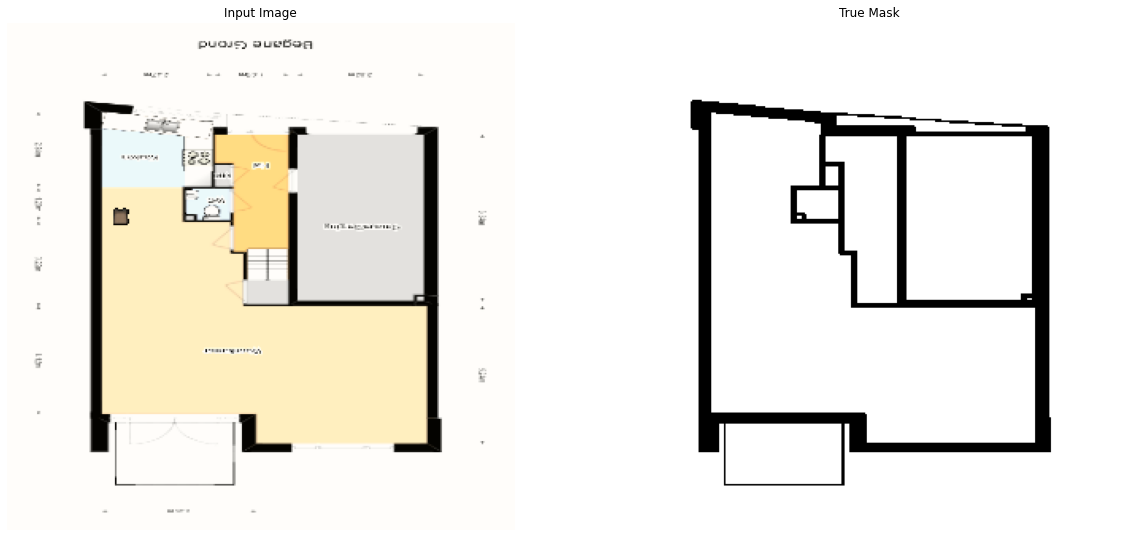

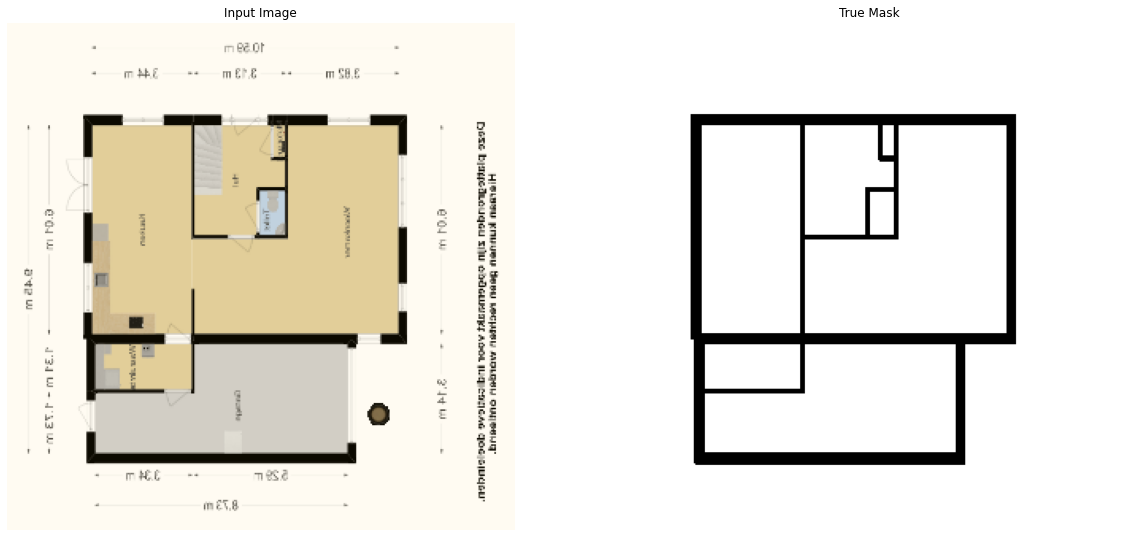

In [69]:
from IPython.display import clear_output
oneHot = True
for images, masks,_ in train_dataset.take(2):
    sample_image, sample_mask = images[0], masks[0]
    if oneHot == True:
        sample_mask = tf.expand_dims(tf.argmax(sample_mask, axis=2),2)
    display([sample_image, sample_mask])

In [ ]:
a, b = np.sum(sample_mask==0), np.sum(sample_mask==1)
c = sample_mask.shape[0]*sample_mask.shape[1]
(a/c), (b/c)

(0.08846628289473685, 0.9115337171052632)

# TRAIN

### Different backbones

In [73]:
base_model_name = 'efficientnetB2'

if base_model_name == 'mobilenet':
    base_model = tf.keras.applications.MobileNetV2(input_shape=target_shape + (3,), include_top=False, weights="imagenet")
    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
elif base_model_name == 'resnet50':
    base_model = tf.keras.applications.ResNet50( include_top=False, weights="imagenet", input_tensor=None, input_shape=target_shape + (3,), pooling=None)
    layer_names = ["conv1_relu",
               "conv2_block3_out",
               "conv3_block4_out",
               "conv4_block6_out",
               "conv5_block3_out"]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
elif base_model_name == 'efficientnetB2':
    base_model = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=target_shape + (3,),
    pooling=None
    )
    layer_names = ['block1b_add', 'block2c_add', 'block3c_add', 'block4d_add', 'block6e_add']

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
elif base_model_name == 'densenet':
    base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=target_shape + (3,),
    pooling=None
    )
 
    layer_names = ['conv1/relu', 'conv2_block6_concat', 'conv3_block12_concat','conv4_block24_concat', 'relu']

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
    

    
  # Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# down_stack.trainable = False

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]  


In [74]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

### Initiate model

In [75]:
OUTPUT_CLASSES = 2
EPOCHS = 40
NUM_STEPS =  image_count//batch_size * EPOCHS
print(f"{EPOCHS} epochs. {image_count} images. {NUM_STEPS} number of steps.\n")

filepath = './checkpoints/unet-mobilenet-res-attention2.ckpt'
# filepath = './checkpoints/unet-densenet-res-attention2.ckpt'
# filepath = './checkpoints/unet-resnet-res-attention2.ckpt'
# filepath = './checkpoints/unet-efficientdet-res-attention2.ckpt'

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=300,
    decay_rate=0.9)

optimizer =tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)


iou_metric = MyMeanIOU(num_classes=2) 

model = unet_model(OUTPUT_CLASSES)
model.compile(
    optimizer=optimizer,
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True),
    metrics=[iou_metric])


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_' + iou_metric.name,
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq="epoch"
)




40 epochs. 691 images. 3440 number of steps.



In [ ]:
# model.fit(train_dataset.map(add_sample_weights), epochs=10, validation_data=val_dataset)#, callbacks=[model_checkpoint_callback])
model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)#, callbacks=[model_checkpoint_callback])

Epoch 1/40
69/69 [==============================] - 40s 321ms/step - loss: 0.0405 - my_mean_iou_2: 0.4495 - val_loss: 3.0060 - val_my_mean_iou_2: 0.0968
Epoch 2/40
69/69 [==============================] - 27s 292ms/step - loss: 0.0212 - my_mean_iou_2: 0.5205 - val_loss: 0.4471 - val_my_mean_iou_2: 0.3836
Epoch 3/40
69/69 [==============================] - 27s 291ms/step - loss: 0.0163 - my_mean_iou_2: 0.5743 - val_loss: 0.3671 - val_my_mean_iou_2: 0.5738
Epoch 4/40
69/69 [==============================] - 27s 290ms/step - loss: 0.0137 - my_mean_iou_2: 0.6207 - val_loss: 0.2548 - val_my_mean_iou_2: 0.6301
Epoch 5/40
69/69 [==============================] - 27s 291ms/step - loss: 0.0122 - my_mean_iou_2: 0.6523 - val_loss: 0.1583 - val_my_mean_iou_2: 0.6608
Epoch 6/40
69/69 [==============================] - 26s 291ms/step - loss: 0.0113 - my_mean_iou_2: 0.6714 - val_loss: 0.1317 - val_my_mean_iou_2: 0.6677
Epoch 7/40
69/69 [==============================] - 26s 292ms/step - loss: 0.0107 

### Evaluate

In [116]:
# filepath = './checkpoints/unet-mobilenet-res-attention2.ckpt'
filepath = './checkpoints/unet-densenet-res-attention2.ckpt'
# filepath = './checkpoints/unet-resnet-res-attention2.ckpt'
# filepath = './checkpoints/unet-efficientdet-res-attention2.ckpt'
model.load_weights(filepath)

In [37]:
filepath = './checkpoints/unet-densenet-res-attention-best.ckpt'
# model.save_weights(filepath)
model.load_weights(filepath)

In [117]:
model.evaluate(val_dataset)

12/12 [==============================] - 2s 150ms/step - loss: 0.0186 - my_mean_iou_1: 0.8550


[0.01858854480087757, 0.8549836874008179]

In [ ]:
# mobilenet my_mean_iou: 0.8665
# resnet my_mean_iou: 0.8767
# efficientnet my_mean_iou: 0.8801
# densenet my_mean_iou: 0.8711

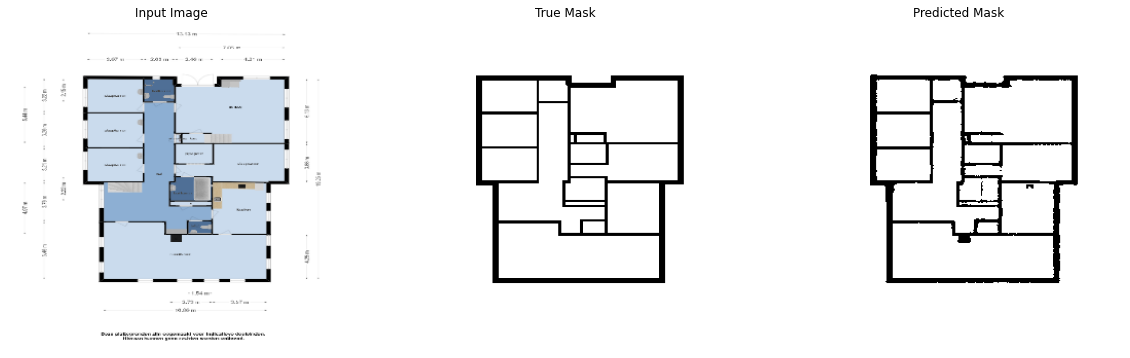

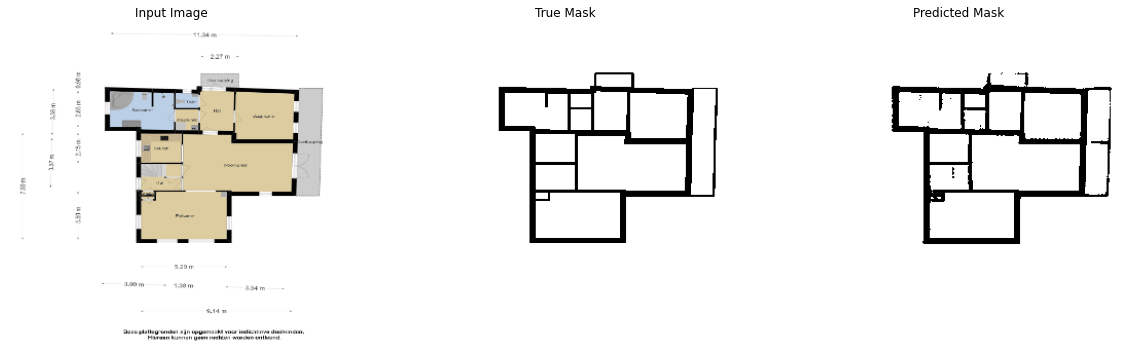

In [ ]:
show_predictions(val_dataset, 2, True)